In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## 1. Absolute Positional Embeddings

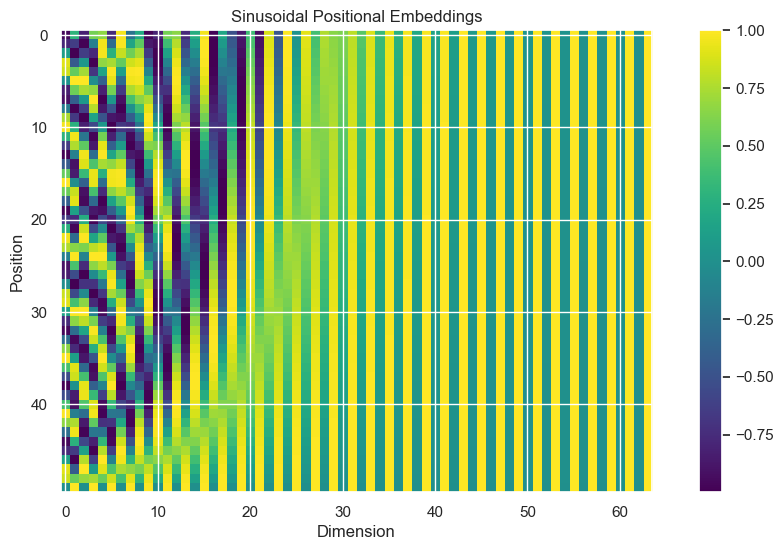

In [23]:
def position_embedding(max_pos, d_model):
    pe = np.zeros((max_pos, d_model))
    position = np.arange(max_pos)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return np.flip(pe,0)

max_pos = 50
d_model = 64
sinusoidal_pe = position_embedding(max_pos, d_model)

plt.figure(figsize=(12, 6))
plt.imshow(sinusoidal_pe, cmap='viridis', aspect='equal')
plt.title("Positional Embeddings")
plt.ylabel("Position")
plt.xlabel("Dimension")
plt.colorbar()
plt.show()

## RoPE:

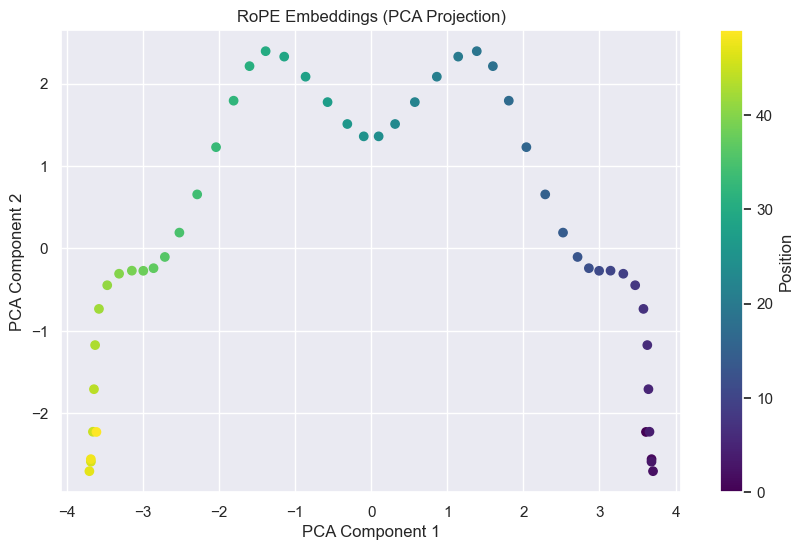

In [13]:
class RoPE:
    def __init__(self, d_model, theta_base=10000.0):
        self.d_model = d_model
        self.theta_base = theta_base
        self.freqs = 1.0 / (self.theta_base ** (np.arange(0, d_model, 2) / d_model))
        
    def rotate(self, x, position):
        seq_len, d_model = x.shape
        angles = position * self.freqs
        cos = np.cos(angles)[None, :]
        sin = np.sin(angles)[None, :]
        
        x_rotated = x.copy()
        x_rotated[:, 0::2] = x[:, 0::2] * cos - x[:, 1::2] * sin
        x_rotated[:, 1::2] = x[:, 1::2] * cos + x[:, 0::2] * sin
        return x_rotated

d_model = 64
positions = np.arange(50)
base_vector = np.random.randn(1, d_model)

rope = RoPE(d_model)
rotated_vectors = np.vstack([rope.rotate(base_vector, p) for p in positions])

pca = PCA(n_components=2)
emb_pca = pca.fit_transform(rotated_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=positions, cmap='viridis')
plt.title("RoPE Embeddings (PCA)")
plt.colorbar(label='Position')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## LongRoPE:

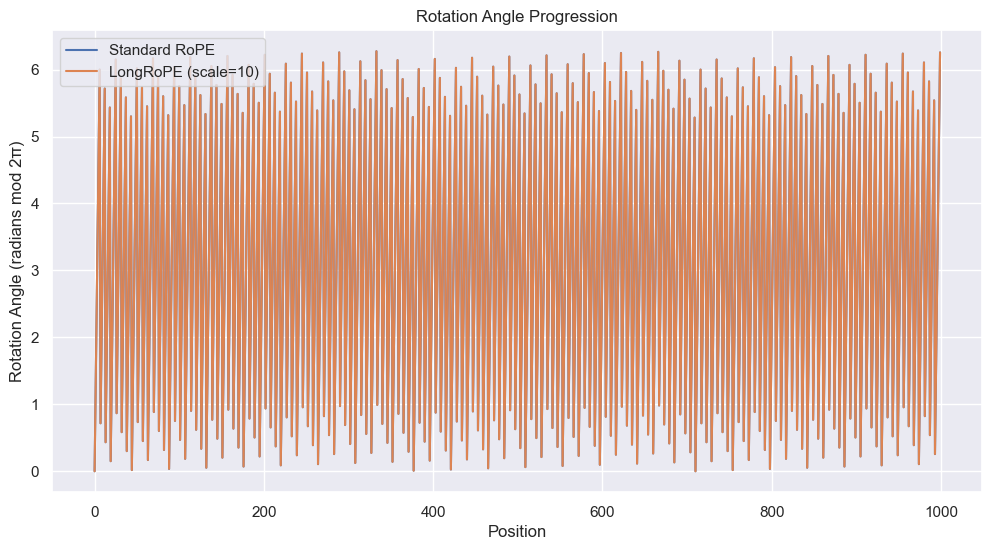

In [28]:
class LongRoPE(RoPE):
    def __init__(self, d_model, theta_base=10000.0, scale_factor=10):
        super().__init__(d_model, theta_base * scale_factor)
        self.scale_factor = scale_factor

rope_standard = RoPE(d_model=64)
rope_long = LongRoPE(d_model=64, scale_factor=10)

positions = np.arange(1000)
angles_standard = positions * rope_standard.freqs[0]
angles_long = positions * rope_long.freqs[0]

plt.figure(figsize=(12, 6))
plt.plot(positions, angles_standard % (2*np.pi), label='Standard RoPE')
plt.plot(positions, angles_long % (2*np.pi), label=f'LongRoPE (scale=10)')
plt.title("Rotation Angle Progression")
plt.xlabel("Position")
plt.ylabel("Rotation Angle (radians mod 2π)")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_1263/1936381922.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  similarities[m, n] = q @ k.T


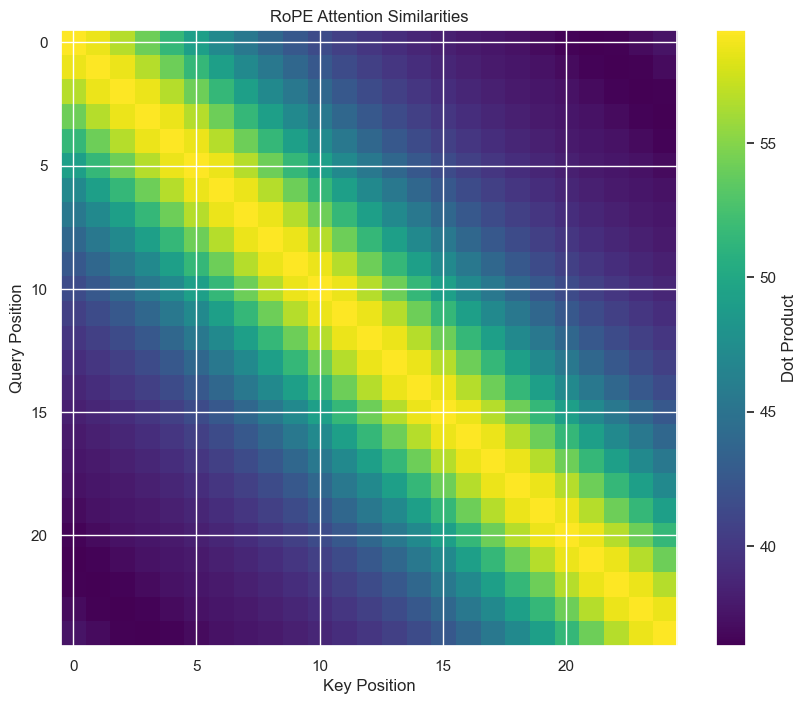

In [15]:
def get_rope_similarity(rope, max_pos):
    similarities = np.zeros((max_pos, max_pos))
    base_vector = np.random.randn(1, d_model)
    
    for m in range(max_pos):
        q = rope.rotate(base_vector, m)
        for n in range(max_pos):
            k = rope.rotate(base_vector, n)
            similarities[m, n] = q @ k.T
            
    return similarities

max_pos = 25
similarities = get_rope_similarity(RoPE(d_model=64), max_pos)

plt.figure(figsize=(10, 8))
plt.imshow(similarities, cmap='viridis')
plt.title("RoPE Attention Similarities")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.colorbar(label='Dot Product')
plt.show()